In [1]:
!pip install augmentor
!pip install opencv-python
!pip install torch torchvision
!pip install --upgrade numpy
!pip install --upgrade tensorflow
!pip install shap

import os
import shutil
import cv2
from PIL import Image
import shutil  
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedKFold

import shutil  
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA

Defaulting to user installation because normal site-packages is not writeable


# Read the Data

In [6]:
# Specify the path to the data directory
path_to_data = 'C:\\Users\\huoqingz\\Desktop\\PAD-UFES-20'

# List all files and folders in the specified directory
files_and_folders = os.listdir(path_to_data)
print(files_and_folders)

['.ipynb_checkpoints', 'Dataprep', 'images', 'metadata.csv', 'pad-ufes-20_parsed_folders.csv', 'pad-ufes-20_parsed_test.csv', 'Untitled.ipynb']


In [7]:
# Define the target folder
destination_folder = 'all_images'

# Create the target folder
os.makedirs(destination_folder, exist_ok=True)

# Define a function to move files to the destination folder
def move_files_to_dest_folder(path, dest):
    for root, _, files in os.walk(path):
        for file in files:
            src_file = os.path.join(root, file)
            dest_file = os.path.join(dest, file)
            shutil.copy(src_file, dest_file)

# Move files from each subfolder to the destination folder
move_files_to_dest_folder(os.path.join(path_to_data, 'images', 'imgs_part_1'), destination_folder)
move_files_to_dest_folder(os.path.join(path_to_data, 'images', 'imgs_part_2'), destination_folder)
move_files_to_dest_folder(os.path.join(path_to_data, 'images', 'imgs_part_3'), destination_folder)

# Print the number of files in the destination folder
print(len(os.listdir(destination_folder)))

2298


In [8]:
metadata = pd.read_csv(os.path.join(path_to_data, 'metadata.csv'))
metadata.head(10)

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
5,PAT_1549,1882,NaN,NaN,NaN,NaN,53,NaN,NaN,NaN,...,NaN,SEK,True,False,False,False,False,True,PAT_1549_1882_230.png,False
6,PAT_778,1471,False,True,GERMANY,ITALY,52,False,FEMALE,False,...,10.0,BCC,False,True,False,True,True,True,PAT_778_1471_835.png,True
7,PAT_117,179,False,False,POMERANIA,POMERANIA,74,True,FEMALE,False,...,10.0,BCC,True,True,True,False,True,True,PAT_117_179_983.png,True
8,PAT_1995,4080,NaN,NaN,NaN,NaN,68,NaN,NaN,NaN,...,NaN,ACK,True,False,False,True,False,False,PAT_1995_4080_695.png,False
9,PAT_705,4015,False,True,GERMANY,GERMANY,58,True,FEMALE,True,...,7.0,ACK,False,True,False,False,False,False,PAT_705_4015_413.png,False


In [62]:
metadata['full_link'] = 'C:\\Users\\huoqingz\\Desktop\\PAD-UFES-20\\Dataprep\\all_images\\' + metadata['img_id']


In [44]:
metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           2298 non-null   object
 1   lesion_id            2298 non-null   int64 
 2   smoke                2298 non-null   object
 3   drink                2298 non-null   object
 4   background_father    2298 non-null   object
 5   background_mother    2298 non-null   object
 6   age                  2298 non-null   int64 
 7   pesticide            2298 non-null   object
 8   gender               2298 non-null   object
 9   skin_cancer_history  2298 non-null   object
 10  cancer_history       2298 non-null   object
 11  has_piped_water      2298 non-null   object
 12  has_sewage_system    2298 non-null   object
 13  fitspatrick          2298 non-null   object
 14  region               2298 non-null   object
 15  diameter_1           2298 non-null   object
 16  diamet

In [82]:
# Checking for null values in each column of the metadata DataFrame
for i in metadata.columns:
    print(i, metadata[str(i)].isnull().sum())

patient_id 0
lesion_id 0
smoke 0
drink 0
background_father 0
background_mother 0
age 0
pesticide 0
gender 0
skin_cancer_history 0
cancer_history 0
has_piped_water 0
has_sewage_system 0
fitspatrick 0
region 0
diameter_1 0
diameter_2 0
diagnostic 0
itch 0
grew 0
hurt 0
changed 0
bleed 0
elevation 0
img_id 0
biopsed 0
full_link 0


In [45]:
# Defining clinical features and image-related columns
clin_feats = ["smoke", "drink", "background_father", "background_mother", "age", "pesticide", "gender", "skin_cancer_history",
                 "cancer_history", "has_piped_water", "has_sewage_system", "fitspatrick", "region", "diameter_1", "diameter_2",
                 "itch", "grew", "hurt", "changed", "bleed", "elevation"]

# Clinical columns related to patient information
clin_ = ["img_id", "diagnostic", "patient_id", "lesion_id", "biopsed"]

In [46]:
"""
Autor: André Pacheco
Email: pacheco.comp@gmail.com

Script to prepare data to train, validate and test PAD-UFES-20 dataset
"""

def split_k_folder_csv(data_csv, col_target, save_path=None, k_folder=5, seed_number=None):
    """
    This function generates k-fold cross-validation folders and adds a new column 'folder' to the dataframe
    :param data_csv (string or pd.DataFrame): path to a csv or a loaded dataframe
    :param col_target (string or list of strings): name(s) of the target(s)/label(s) column(s)
    :param k_folder(int): number of folders for cross-validation
    :param save_path (string): path to save the result of this function. Default is None
    :param seed_number (number, optional): seed number to ensure reproducibility
    return (pd.DataFrame): dataframe with the new column
    """

    print("-" * 50)
    print("- Generating the {}-folders...".format(k_folder))

    # Flag for creating a new target column - for dealing with multiple target stratification
    _multiple_targets = False

    # Loading the data_csv
    if isinstance(data_csv, str):
        data_csv = pd.read_csv(data_csv)

    # Selecting the targets
    if type(col_target).__name__ == "list":
        # If the target is received as a list of strings
        # Create a new data_csv column as the concatenation of the multiple targets
        data_csv['target'] = ""
        for i in range(len(col_target)):
            data_csv['target'] += data_csv[col_target[i]].astype(str)
            if (i < len(col_target)-1):
                data_csv['target'] += "_"
        
        # Storing the new target column - result of merging all the target values        
        target = data_csv['target']

        # Setting the multiple target flag
        _multiple_targets = True
    else:
        # If the target is received as a string
        target = data_csv[col_target]    
    skf = StratifiedKFold(k_folder, shuffle=True, random_state=seed_number)
    
    data_csv['folder'] = None
    for folder_number, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(target)), target)):
        data_csv.loc[val_idx, 'folder'] = folder_number + 1

    if save_path is not None:
        if _multiple_targets:
            data_csv.drop(['target'], axis=1)
        data_csv.to_csv(save_path, index=False)

    print("- Done!")
    print("-" * 50)

    return data_csv

In [47]:
"""
Autor: André Pacheco
Email: pacheco.comp@gmail.com

Script to prepare data to train, validate and test PAD-UFES-20 dataset
"""

def label_categorical_to_number (data_csv, col_target, col_target_number=None, save_path=None):
    """
    This function converts a label from categorical to number. The values are converted to code in alphabetic ordem.
    Example: for a set of labels ['A', 'B', 'C'] it converts to [0, 1, 2].
    :param data_csv (string or pd.DataFrame): the path for a csv or a dataframe already loaded
    :param col_target (string): the name of the target/label column
    :param col_target_number (string): if you want to control the name of the column with the convert number, just set
    the name here, otherwise it will set <col_target>_number
    :param save_path (string): the path to save the result of this function. Default is None
    return: it returns the same dataframe with an additional column called <col_target>_number or col_target_number
    """

    # Loading the data_csv
    if isinstance(data_csv, str):
        data_csv = pd.read_csv(data_csv)

    data_csv[col_target] = data_csv[col_target].astype('category')
    if col_target_number is None:
        data_csv[col_target + '_number'] = data_csv[col_target].cat.codes
    else:
        data_csv[col_target_number] = data_csv[col_target].cat.codes

    if save_path is not None:
        data_csv.to_csv(save_path, index=False)

    return data_csv

# Clinical Data Processing:

In [49]:
# Define the metadata file path
metadata_path = os.path.join(path_to_data, 'metadata.csv')

# Read the metadata.csv file
metadata = pd.read_csv(metadata_path)

# Fill missing values with "EMPTY"
metadata = metadata.fillna("EMPTY")

# Initialize a list for new clinical feature columns
new_cli_cols = []

# Iterate over the clinical feature list
for c in clin_feats:
    # If the feature is "age", "diameter_1", or "diameter_2", directly add it to the new clinical feature columns list
    if c in ["age", "diameter_1", "diameter_2"]:
        new_cli_cols.append(c)
        continue
    
    # For other features, combine their unique values with the feature name and add to the new clinical feature columns list
    vals = [c+"_"+str(v) for v in metadata[c].unique()]
    try:
        vals.remove(c+"_EMPTY")
    except:
        pass
    new_cli_cols += vals

# Create an empty dictionary to store the new data
new_df = {c: [] for c in new_cli_cols}

# Iterate over each row of metadata
for idx, row in metadata.iterrows():
    _aux = []
    _aux_in = []
    # Iterate over the clinical feature list
    for col in clin_feats:
        data_row = row[col]

        # Skip if the value is 'EMPTY'
        if data_row == 'EMPTY':
            pass
        elif col in ["age", "diameter_1", "diameter_2"]:
            # If it's "age", "diameter_1", or "diameter_2", append to auxiliary list _aux_in and add its value to the new data dictionary
            _aux_in.append(col)
            new_df[col].append(data_row)
            continue
        else:
            # Otherwise, append the combination of feature name and value to the auxiliary list _aux
            _aux.append(col+"_"+str(data_row))

    # Set the corresponding positions to 1 or 0 in the new data dictionary based on the values in auxiliary lists _aux and _aux_in
    for x in new_df:
        if x in _aux:
            new_df[x].append(1)
        elif x not in _aux_in:
            new_df[x].append(0)

# Convert the dictionary to a DataFrame
new_df = pd.DataFrame.from_dict(new_df)

# Add clinical feature columns to the DataFrame
for col in clin_:
    new_df[col] = metadata[col]

# Perform data splitting and save the test dataset
data = split_k_folder_csv(new_df, "diagnostic",
                          save_path=None, k_folder=6, seed_number=8)
data_test = data[data['folder'] == 6]
data_test.to_csv(os.path.join(path_to_data, "pad-ufes-20_parsed_test.csv"), index=False)

# Convert labels in the test dataset to numerical values
label_categorical_to_number(os.path.join(path_to_data, "pad-ufes-20_parsed_test.csv"), "diagnostic",
                            col_target_number="diagnostic_number",
                            save_path=os.path.join(path_to_data, "pad-ufes-20_parsed_test.csv"))

# Reset the index of the training dataset and perform data splitting
data_train = data[data['folder'] != 6]
data_train = data_train.reset_index(drop=True)
data_train = split_k_folder_csv(data_train, "diagnostic",
                                save_path=None, k_folder=5, seed_number=8)

# Convert labels in the training dataset to numerical values and save as a CSV file
label_categorical_to_number(data_train, "diagnostic", col_target_number="diagnostic_number",
                             save_path=os.path.join(path_to_data, "pad-ufes-20_parsed_folders.csv"))

--------------------------------------------------
- Generating the 6-foders...
- Done!
--------------------------------------------------
--------------------------------------------------
- Generating the 5-foders...
- Done!
--------------------------------------------------


,smoke_False,smoke_True,drink_False,drink_True,background_father_POMERANIA,background_father_GERMANY,background_father_BRAZIL,background_father_NETHERLANDS,background_father_ITALY,background_father_POLAND,...,elevation_False,elevation_True,elevation_UNK,img_id,diagnostic,patient_id,lesion_id,biopsed,folder,diagnostic_number
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1516_1765_530.png,NEV,PAT_1516,1765,False,4,3
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,PAT_46_881_939.png,BCC,PAT_46,881,True,3,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1545_1867_547.png,ACK,PAT_1545,1867,False,4,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1989_4061_934.png,ACK,PAT_1989,4061,False,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,PAT_1549_1882_230.png,SEK,PAT_1549,1882,False,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,1,0,1,0,1,0,0,0,0,0,...,0,1,0,PAT_273_421_905.png,BCC,PAT_273,421,True,1,1
1911,1,0,1,0,1,0,0,0,0,0,...,0,1,0,PAT_491_934_46.png,SCC,PAT_491,934,True,4,4
1912,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1708_3156_175.png,ACK,PAT_1708,3156,False,1,0
1913,1,0,1,0,1,0,0,0,0,0,...,1,0,0,PAT_46_880_140.png,BCC,PAT_46,880,True,1,1


In [50]:
# Selecting the test dataset
data_test = data[data['folder'] == 6]

# Resetting the index of the test dataset
data_test = data_test.reset_index(drop=True)

# Converting the labels in the test dataset from categorical to numerical
label_categorical_to_number(data_test, "diagnostic", col_target_number="diagnostic_number",
                             save_path=os.path.join(path_to_data, "pad-ufes-20_parsed_test.csv"))

,smoke_False,smoke_True,drink_False,drink_True,background_father_POMERANIA,background_father_GERMANY,background_father_BRAZIL,background_father_NETHERLANDS,background_father_ITALY,background_father_POLAND,...,elevation_False,elevation_True,elevation_UNK,img_id,diagnostic,patient_id,lesion_id,biopsed,folder,diagnostic_number
0,1,0,0,1,1,0,0,0,0,0,...,0,1,0,PAT_684_1302_588.png,BCC,PAT_684,1302,True,6,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1995_4080_695.png,ACK,PAT_1995,4080,False,6,0
2,1,0,1,0,0,1,0,0,0,0,...,0,1,0,PAT_759_1538_566.png,BCC,PAT_759,1538,True,6,1
3,1,0,1,0,1,0,0,0,0,0,...,1,0,0,PAT_106_159_325.png,BCC,PAT_106,159,True,6,1
4,1,0,1,0,0,1,0,0,0,0,...,1,0,0,PAT_42_58_13.png,BCC,PAT_42,58,True,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,1,0,1,0,1,0,0,0,0,0,...,0,1,0,PAT_987_1859_724.png,ACK,PAT_987,1859,True,6,0
379,0,0,0,0,0,0,0,0,0,0,...,0,1,0,PAT_1713_3179_888.png,SEK,PAT_1713,3179,False,6,5
380,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1407_1402_562.png,ACK,PAT_1407,1402,False,6,0
381,0,0,0,0,0,0,0,0,0,0,...,1,0,0,PAT_1343_1217_404.png,SEK,PAT_1343,1217,False,6,5


In [51]:
print('train  ->', data_train.shape)
print('test  ->', data_test.shape)

train  -> (1915, 88)
test  -> (383, 88)


In [19]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 88 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   smoke_False                    1915 non-null   int64   
 1   smoke_True                     1915 non-null   int64   
 2   drink_False                    1915 non-null   int64   
 3   drink_True                     1915 non-null   int64   
 4   background_father_POMERANIA    1915 non-null   int64   
 5   background_father_GERMANY      1915 non-null   int64   
 6   background_father_BRAZIL       1915 non-null   int64   
 7   background_father_NETHERLANDS  1915 non-null   int64   
 8   background_father_ITALY        1915 non-null   int64   
 9   background_father_POLAND       1915 non-null   int64   
 10  background_father_UNK          1915 non-null   int64   
 11  background_father_PORTUGAL     1915 non-null   int64   
 12  background_father_BRASIL       191

# Target

In [52]:
# Look-up table
diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

# A function for encoding classes
def create_class(X):
    if X == 'BCC':
        return 0
    elif X =='ACK':
        return 1
    elif X == 'NEV':
        return 2
    elif X == 'SEK':
        return 3
    elif X == 'SCC':
        return 4
    elif X == 'MEL':
        return 5
    else:
        print('Error: Class not found')

# Applying the function and dropping 'diagnostic' feature to avoid target leakage
data_train['encoded_class'] = data_train['diagnostic'].apply(create_class)
data_train.drop(['diagnostic'], axis=1, inplace=True)
data_train.sort_values(by='patient_id', ascending=True, inplace=True, ignore_index=True)

data_test['encoded_class'] = data_test['diagnostic'].apply(create_class)
data_test.drop(['diagnostic'], axis=1, inplace=True)
data_test.sort_values(by='patient_id', ascending=True, inplace=True, ignore_index=True)

In [53]:
# Calculating class weights
counts = np.bincount(data_train['encoded_class'])

# Calculating weights for each class
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
weight_for_2 = 1.0 / counts[2]
weight_for_3 = 1.0 / counts[3]
weight_for_4 = 1.0 / counts[4]
weight_for_5 = 1.0 / counts[5]

# Creating a dictionary for class weights
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5}

class_weight

{0: 0.0014204545454545455,
 1: 0.001644736842105263,
 2: 0.004901960784313725,
 3: 0.00510204081632653,
 4: 0.00625,
 5: 0.023255813953488372}

# Image

In [59]:
# Adding full path to image files in train and test datasets
data_train['full_link'] = 'C:\\Users\\huoqingz\\Desktop\\PAD-UFES-20\\Dataprep\\all_images\\' + data_train['img_id']
data_test['full_link'] = 'C:\\Users\\huoqingz\\Desktop\\PAD-UFES-20\\Dataprep\\all_images\\' + data_test['img_id']

Text(0.5, 1.0, '1')

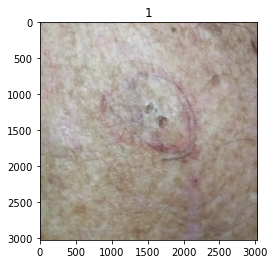

In [89]:
# Accessing images based on the previous setup
random_row = np.random.choice(data_train.index)

im_id = data_train.loc[random_row, 'img_id']
label = data_train.loc[random_row, 'encoded_class']

impath = os.path.join(destination_folder, im_id)
image = plt.imread(impath)
plt.imshow(image)
plt.title(label)


In [90]:
# Reading the image using OpenCV
image = cv2.imread(impath)

# Displaying the shape of the image
print(image.shape)

(3024, 3024, 3)


In [35]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    return img, label

In [85]:
# Feature Extraction 
# Creating Custom ConvMixer Layer
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        # Define layers
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
       # Forward pass
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

In [55]:
# Constants
FEATURES = 256
IMG_SIZE = 32, 32
BATCH_SIZE = 256
SEED = 55
AUTO = tf.data.AUTOTUNE

# Input layer
inp = Input(shape=(*IMG_SIZE, 3))

# Initial Convolutional Layer
X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

# ConvMixer Blocks
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_8')(X)

# Global Average Pooling Layer
X = GlobalAveragePooling2D(name='the_last_pooling_layer')(X)

# Output layer
out = Dense(6, activation='softmax')(X)

# Model
model = Model(inputs=inp, outputs=out)
model.summary()
    
# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)]) 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_1 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_2 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_3 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_4 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_5 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_6 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_7 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONVMIXER_8 (ConvMixerBlock)    │ (None, 16, 16, 256)    │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ the_last_pooling_layer          │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,862 (2.30 MB)

 Trainable params: 593,158 (2.26 MB)

 Non-trainable params: 8,704 (34.00 KB)

# Creating dataset loaders and tf.datasets


In [60]:
# Creating train dataset loader with image paths and encoded classes
train_loader = tf.data.Dataset.from_tensor_slices((data_train['full_link'], data_train['encoded_class']))

# Creating train dataset pipeline with preprocessing and augmentation
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls=AUTO)
                 .map(augmentation, num_parallel_calls=AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(BATCH_SIZE * 10)
                 .prefetch(AUTO))

# Train dataset without shuffle and augmentation
# Creating train dataset loader for feature extraction
train_loader_for_feature = tf.data.Dataset.from_tensor_slices((data_train['full_link'], data_train['encoded_class']))

# Creating train dataset pipeline for feature extraction
train_dataset_for_feature = (train_loader_for_feature
                             .map(img_preprocessing, num_parallel_calls=AUTO)
                             .batch(BATCH_SIZE)
                             .prefetch(AUTO))

# Creating test dataset loader with image paths and encoded classes
test_loader = tf.data.Dataset.from_tensor_slices((data_test['full_link'], data_test['encoded_class']))

# Creating test dataset pipeline with preprocessing
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls=AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [61]:
# Training feature extraction model and saving

# Training the model on the train dataset
history = model.fit(train_dataset, 
                    batch_size=BATCH_SIZE, 
                    epochs=75, 
                    class_weight=class_weight, 
                    verbose=0)

In [65]:
model.save('convmixer_feature_extractor.keras')

In [68]:
# Loading the feature extraction model
feature_extr = tf.keras.models.load_model('C:\\Users\\huoqingz\\Desktop\\PAD-UFES-20\\Dataprep\\convmixer_feature_extractor.keras', 
                                         custom_objects={"ConvMixerBlock": ConvMixerBlock })

# Creating the feature extraction model 
feature_extractor_model = Model(inputs=feature_extr.input, outputs=feature_extr.get_layer('the_last_pooling_layer').output)


In [69]:
pred = feature_extractor_model.predict(train_dataset_for_feature)


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 899ms/step


In [77]:
# Applying PCA with 41 components, capturing nearly 0.98 variance ratio
pca_ = PCA(41)
pred_pca = pca_.fit_transform(pred)

# Creating new feature column names
new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
# Creating DataFrame with PCA transformed features
pred_pca = pd.DataFrame(pred_pca, columns=new_feature_column_names)

# Displaying the first few rows of the PCA transformed features
pred_pca.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,2.184590,-1.702565,-0.403729,-0.500497,-1.033449,-0.670126,-0.281746,0.343840,-0.189140,0.052433,...,0.317130,0.083013,-0.088532,-0.132418,-0.050755,0.279228,0.129425,-0.079842,0.023578,-0.005242
1,-2.918153,5.366031,0.692126,-0.994898,-1.330088,1.843826,0.861246,-0.965753,0.489145,-0.389885,...,0.123911,-0.004416,0.015607,-0.303741,0.137200,0.039244,0.100612,-0.100173,-0.021346,0.120248
2,4.577345,0.008925,-1.666558,-0.117730,0.628427,0.032003,-0.189824,0.085788,0.690856,-0.640441,...,-0.277385,-0.105178,0.047441,-0.072377,0.388361,-0.246442,-0.054109,0.077547,-0.010611,0.118246
3,-3.038027,0.044540,0.632309,-2.189497,-1.045824,0.388439,-1.028343,0.413315,-0.143487,-0.265277,...,-0.130110,0.186103,0.021635,-0.155881,-0.115873,0.026340,-0.158392,0.097082,0.058816,0.183728
4,0.491462,-3.544882,-0.369102,-2.831966,-0.473472,-0.796283,0.345486,-0.851426,-0.052560,1.114879,...,0.020786,0.068077,-0.191336,0.059885,-0.030278,0.042227,-0.088418,0.246640,-0.206339,0.067374


In [98]:
# Merging the imaging features with metadata features
train_data_last = pd.concat([data_train, pred_pca], axis=1)
train_data_last.drop(['full_link'], axis=1, inplace=True)
train_data_last.head()

,smoke_False,smoke_True,drink_False,drink_True,background_father_POMERANIA,background_father_GERMANY,background_father_BRAZIL,background_father_NETHERLANDS,background_father_ITALY,background_father_POLAND,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,0,1,1,0,0,1,0,0,0,0,...,0.317130,0.083013,-0.088532,-0.132418,-0.050755,0.279228,0.129425,-0.079842,0.023578,-0.005242
1,1,0,1,0,1,0,0,0,0,0,...,0.123911,-0.004416,0.015607,-0.303741,0.137200,0.039244,0.100612,-0.100173,-0.021346,0.120248
2,1,0,1,0,1,0,0,0,0,0,...,-0.277385,-0.105178,0.047441,-0.072377,0.388361,-0.246442,-0.054109,0.077547,-0.010611,0.118246
3,0,0,0,0,0,0,0,0,0,0,...,-0.130110,0.186103,0.021635,-0.155881,-0.115873,0.026340,-0.158392,0.097082,0.058816,0.183728
4,0,0,0,0,0,0,0,0,0,0,...,0.020786,0.068077,-0.191336,0.059885,-0.030278,0.042227,-0.088418,0.246640,-0.206339,0.067374


In [99]:
# Extracting deep learning features as Images_data_X
Images_data = pred_pca

# Metadata features as Tabular_data_Z
# Filter out irrelevant columns from Tabular_data = data_train
Tabular_data = data_train.drop(['img_id', 'patient_id', 'lesion_id', 'biopsed', 'folder', 'diagnostic_number', 'encoded_class', 'full_link'], axis=1)

# Splitting features and Target_Y
Target = train_data_last.pop('encoded_class')


# Print a part of Images_data
print("Images_data sample:")
print(Images_data.head())

# Print the shape of Images_data
print("Images_data shape ->", Images_data.shape)

# Print a part of Tabular_data
print("\nTabular_data sample:")
print(Tabular_data.head())

# Print the shape of Tabular_data
print("Tabular_data shape ->", Tabular_data.shape)

# Print a part of Target
print("\nTarget sample:")
print(Target.head())

# Print the shape of Target
print("Target shape ->", Target.shape)


Images_data sample:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   2.184590  -1.702565  -0.403729  -0.500497  -1.033449  -0.670126   
1  -2.918153   5.366031   0.692126  -0.994898  -1.330088   1.843826   
2   4.577345   0.008925  -1.666558  -0.117730   0.628427   0.032003   
3  -3.038027   0.044540   0.632309  -2.189497  -1.045824   0.388439   
4   0.491462  -3.544882  -0.369102  -2.831966  -0.473472  -0.796283   

   feature_7  feature_8  feature_9  feature_10  ...  feature_32  feature_33  \
0  -0.281746   0.343840  -0.189140    0.052433  ...    0.317130    0.083013   
1   0.861246  -0.965753   0.489145   -0.389885  ...    0.123911   -0.004416   
2  -0.189824   0.085788   0.690856   -0.640441  ...   -0.277385   -0.105178   
3  -1.028343   0.413315  -0.143487   -0.265277  ...   -0.130110    0.186103   
4   0.345486  -0.851426  -0.052560    1.114879  ...    0.020786    0.068077   

   feature_34  feature_35  feature_36  feature_37  feature_38  feature_39  \
0